# Full Year 2026 Forecast & Historical Benchmark
## Objective
Generate a complete daily forecast for **Jan 1, 2026 to Dec 31, 2026** (365 Days) and overlay it against 2021-2025 history.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder

# 1. Load Data
df = pd.read_csv('shipment_booking_data_2021_2025.csv')
df['booking_date'] = pd.to_datetime(df['booking_date'])

# Daily Resample
df_daily = df.set_index('booking_date').groupby([
    'company_name', 
    pd.Grouper(freq='D')
])['shipment_type'].value_counts().unstack(fill_value=0).reset_index()
df_daily.columns.name = None

# 2. Feature Engineering (Setup for Training)
df_daily = df_daily.sort_values(['company_name', 'booking_date']).reset_index(drop=True)
target_cols = ['Air', 'Express', 'International', 'Surface']
feat_cols = []

for col in target_cols:
    if col not in df_daily.columns: df_daily[col] = 0
    # Targets
    df_daily[f'target_{col}'] = df_daily.groupby('company_name')[col].shift(-1)
    # Features
    df_daily[f'lag_1_{col}'] = df_daily.groupby('company_name')[col].shift(0)
    feat_cols.append(f'lag_1_{col}')
    df_daily[f'lag_7_{col}'] = df_daily.groupby('company_name')[col].shift(6)
    feat_cols.append(f'lag_7_{col}')
    df_daily[f'roll_7_{col}'] = df_daily.groupby('company_name')[col].transform(lambda x: x.rolling(7, min_periods=1).mean())
    feat_cols.append(f'roll_7_{col}')

df_daily['day_of_week'] = df_daily['booking_date'].dt.dayofweek
df_daily['day'] = df_daily['booking_date'].dt.day
df_daily['month'] = df_daily['booking_date'].dt.month
feat_cols.extend(['day_of_week', 'day', 'month'])

le = LabelEncoder()
df_daily['company_encoded'] = le.fit_transform(df_daily['company_name'])
feat_cols.append('company_encoded')

df_train = df_daily.dropna().copy()
print("Training models on full history...")

# Train XGBoost Models
models = {}
for target in target_cols:
    # Using params from best benchmark run
    m = XGBRegressor(n_estimators=600, learning_rate=0.04, max_depth=7, random_state=42)
    m.fit(df_train[feat_cols], df_train[f'target_{target}'])
    models[target] = m
print("Models Trained.")

Training models on full history...
Models Trained.


## 365-Day Recursive Forecast

In [2]:
# Start Simulation from last known data (Dec 31, 2025)
# We need to maintain a 'growing' dataframe to correctly calculate rolling means and lags
# for 365 steps. 

companies = df_daily['company_name'].unique()
simulation_history = df_daily.copy() # Will append predictions here

start_date = pd.Timestamp('2026-01-01')
end_date = pd.Timestamp('2026-12-31')
date_range = pd.date_range(start_date, end_date, freq='D')

print(f"Forecasting {len(date_range)} days for {len(companies)} companies. This may take a moment...")

for i, current_date in enumerate(date_range):
    if i % 30 == 0: print(f"Processing Month: {current_date.month_name()}")
    
    # We need features for 'current_date'. These depend on data UP TO yesterday.
    # We construct a temporary feature row for each company.
    
    # Optimization: Instead of re-rolling entire history, we just subset the last 10 days
    # for feature calc.
    recent_history = simulation_history.groupby('company_name').tail(10).copy()
    
    # Now, we need to pretend 'today' involves calculating features from this recent_history
    # But standard rolling requires the row to exist. So we append a dummy row for today.
    
    new_rows = []
    for comp in companies:
        row = {'booking_date': current_date, 'company_name': comp, 'company_encoded': le.transform([comp])[0]}
        # Initialize vols as 0 (will fill with prediction)
        for t in target_cols: row[t] = 0 
        new_rows.append(row)
        
    temp_df = pd.DataFrame(new_rows)
    
    # Combine history + dummy 'today' to compute features
    combined = pd.concat([recent_history, temp_df], ignore_index=True)
    combined = combined.sort_values(['company_name', 'booking_date']).reset_index(drop=True)
    
    # Just calc features for the last row (which is 'today')
    # Manual Feature Calculation is faster/safer here than pandas full transform
    # But to prevent bug, we re-use logic vectorised on small window
    for col in target_cols:
         combined[f'lag_1_{col}'] = combined.groupby('company_name')[col].shift(1) # shift(1) means lag 1 relative to index
         combined[f'lag_7_{col}'] = combined.groupby('company_name')[col].shift(7)
         combined[f'roll_7_{col}'] = combined.groupby('company_name')[col].transform(lambda x: x.shift(1).rolling(7, min_periods=1).mean())
    
    combined['day_of_week'] = combined['booking_date'].dt.dayofweek
    combined['day'] = combined['booking_date'].dt.day
    combined['month'] = combined['booking_date'].dt.month
    
    # Extract the rows for 'current_date'
    todays_features = combined[combined['booking_date'] == current_date].copy()
    
    # PREDICT
    preds = []
    for target in target_cols:
        p = models[target].predict(todays_features[feat_cols])
        todays_features[target] = np.maximum(0, p) # Fill the volume columns

    # Append PREDICTED rows back to simulation_history so they become history for tomorrow
    # We keep only relevant columns to save memory if needed
    cols_to_keep = ['booking_date', 'company_name', 'company_encoded'] + target_cols
    simulation_history = pd.concat([simulation_history, todays_features[cols_to_keep]], ignore_index=True)

# Filter to just 2026
forecast_2026 = simulation_history[simulation_history['booking_date'].dt.year == 2026].copy()
forecast_2026['Total_Vol'] = forecast_2026[target_cols].sum(axis=1)

forecast_2026.to_csv('full_year_forecast_2026.csv', index=False)
print("Forecast Complete. Saved to full_year_forecast_2026.csv")

Forecasting 365 days for 8 companies. This may take a moment...
Processing Month: January
Processing Month: January
Processing Month: March
Processing Month: April
Processing Month: May
Processing Month: May
Processing Month: June
Processing Month: July
Processing Month: August
Processing Month: September
Processing Month: October
Processing Month: November
Processing Month: December
Forecast Complete. Saved to full_year_forecast_2026.csv


## 2026 Seasonality Benchmark (The "Spaghetti Plot")

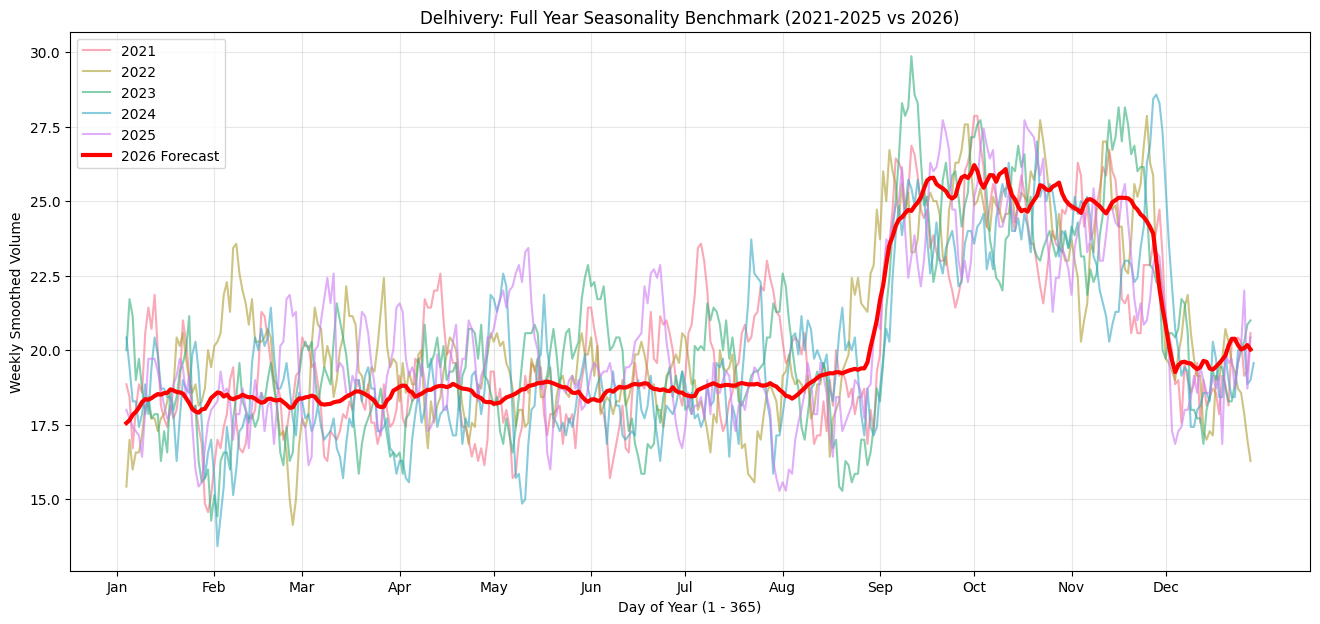

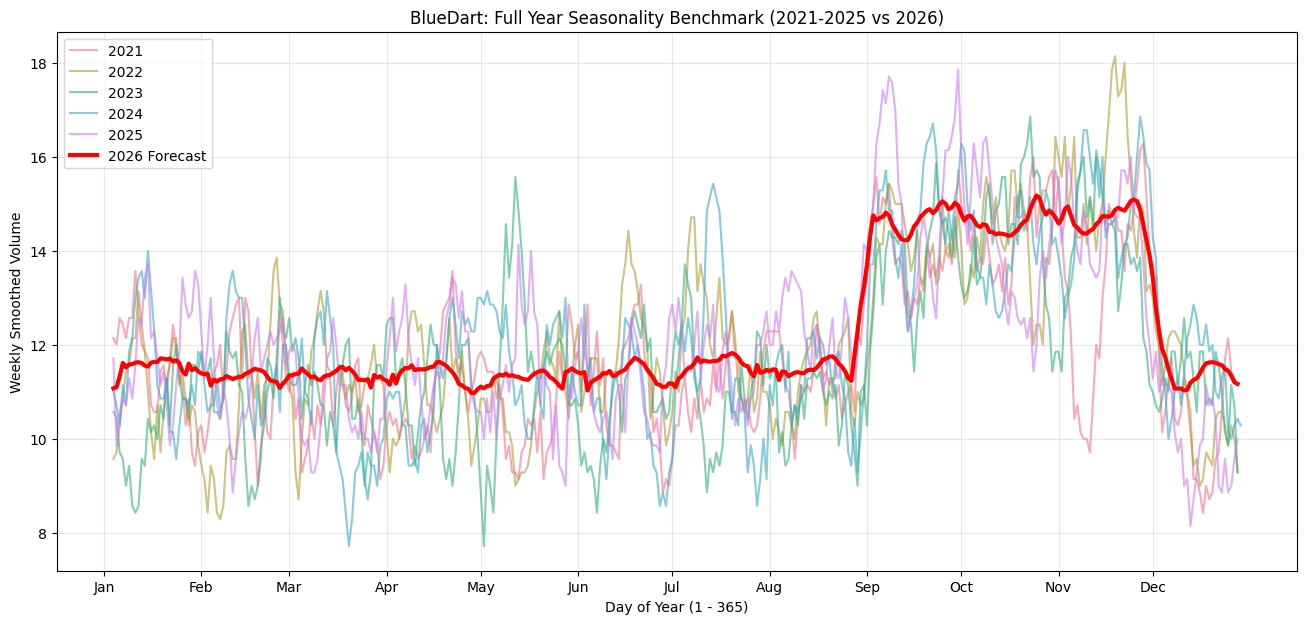

In [3]:
def plot_full_year_comparison(company_name):
    plt.figure(figsize=(16, 7))
    
    # 1. Get History
    hist = df_daily[df_daily['company_name'] == company_name].copy()
    hist['Total_Vol'] = hist[target_cols].sum(axis=1)
    
    # 2. Get Forecast
    pred = forecast_2026[forecast_2026['company_name'] == company_name].copy()
    
    # 3. Plot Each Year
    # We normalize X-axis to Day-of-Year (1 to 365)
    
    # Plot History (Faint lines)
    years = sorted(hist['booking_date'].dt.year.unique())
    colors = sns.color_palette("husl", n_colors=len(years))
    
    for i, year in enumerate(years):
        y_data = hist[hist['booking_date'].dt.year == year]
        # Group by DayOfYear to smooth multiple entries if any (should define unique, but safe)
        y_data = y_data.set_index('booking_date')
        # Use DayOfYear integer for X axis
        x_doy = y_data.index.dayofyear
        y_vol = y_data['Total_Vol'].rolling(7, center=True).mean() # Smoothed for visual clarity
        
        plt.plot(x_doy, y_vol, label=f"{year}", color=colors[i], alpha=0.6, linewidth=1.5)

    # Plot 2026 Forecast (Bold Red)
    pred = pred.set_index('booking_date')
    x_doy_pred = pred.index.dayofyear
    y_vol_pred = pred['Total_Vol'].rolling(7, center=True).mean() # Smoothed
    
    plt.plot(x_doy_pred, y_vol_pred, label="2026 Forecast", color='red', linewidth=3.0)
    
    # Formatting
    plt.title(f"{company_name}: Full Year Seasonality Benchmark (2021-2025 vs 2026)")
    plt.xlabel("Day of Year (1 - 365)")
    plt.ylabel("Weekly Smoothed Volume")
    
    # Add month markers on X axis
    month_starts = [pd.Timestamp(f'2026-{m}-01').dayofyear for m in range(1, 13)]
    month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    plt.xticks(month_starts, month_names)
    
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_full_year_comparison('Delhivery')
plot_full_year_comparison('BlueDart')